In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [112]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, load_model_config
from src.vit_data import load_cell_cycle_data
import importlib

model_dir = 'output/cell_cycle_24x128_2chan_p1_logfold_simple_20220819_319e'

config_path = f"{model_dir.replace('/', '.')}.config"
config = importlib.import_module(config_path)
vit = load_model_config(config, legacy=False)

vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)


In [188]:
vit_data.all_imgs_untransformed.shape

(57551, 2, 24, 128)

In [189]:
img.shape

(24, 128)

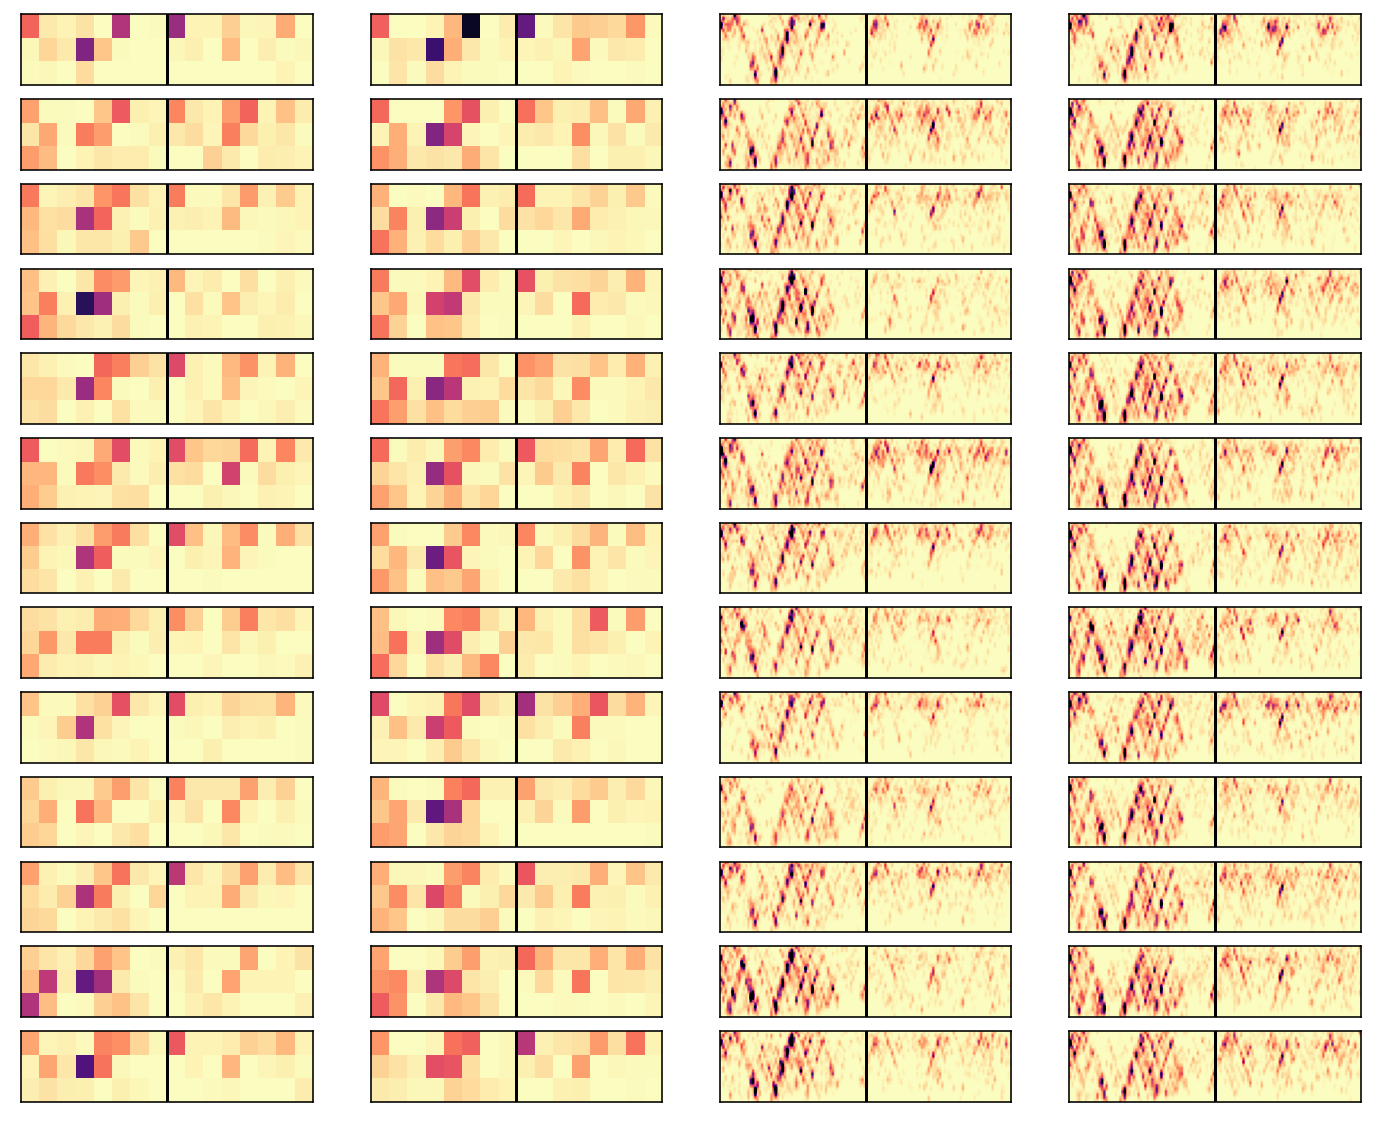

In [241]:
import cv2

imgs = vit_data.all_imgs_untransformed
scale_down = 8
orig_shape = img.shape
new_shape = (img.shape[1]//scale_down, img.shape[0]//scale_down)
    
def plt_hm(gene_name, time, replicate, imgs, img_shape=None):

    idx = vit_data.index_for(gene_name, time)
    img = np.array(imgs[idx, replicate])
    if img_shape is not None:
        img_resize = cv2.resize(img, img_shape)
    else: img_resize = img

    plt.imshow(img_resize, origin='lower', vmin=0, vmax=0.25, cmap='magma_r', aspect='auto',
              extent=[-8, 8, 0, 3])
    plt.axvline(0, c='black')
    plt.yticks([])
    plt.xticks([])
    return img_resize
    
    
times = list(set(vit_data.times))
gene_name = 'CLB2'

new_imgs = np.zeros((len(times), 2, new_shape[1], new_shape[0]))

plt.figure(figsize=(12, 10))
for i in range(len(times)):
    
    time = times[i]    
    
    plt.subplot(len(times), 4, (i*4)+1)
    new_imgs[i, 0] = plt_hm(gene_name, time, 0, imgs, new_shape)
        
    plt.subplot(len(times), 4, (i*4)+2)
    new_imgs[i, 1] = plt_hm(gene_name, time, 1, imgs, new_shape)
    
    plt.subplot(len(times), 4, (i*4)+3)
    plt_hm(gene_name, time, 0, imgs, None)
    
    plt.subplot(len(times), 4, (i*4)+4)
    plt_hm(gene_name, time, 1, imgs, None)
    

In [229]:
new_imgs.shape

(13, 2, 6, 32)

In [249]:
np.sum(new_imgs[0, 0]), np.sum(new_imgs[0, 1])

(0.7821681959660367, 1.1129334458704636)

In [262]:
new_imgs.shape

(13, 2, 3, 16)

In [256]:
scaled_imgs = np.zeros_like(new_imgs)

time, rep = 0, 0

for time in range(new_imgs.shape[0]):
    for rep in range(new_imgs.shape[1]):
        img_sum = np.sum(new_imgs[time, rep])
        scaled_imgs[time, rep] = new_imgs[time, rep] / img_sum


In [261]:
scaled_imgs.shape

(13, 2, 3, 16)

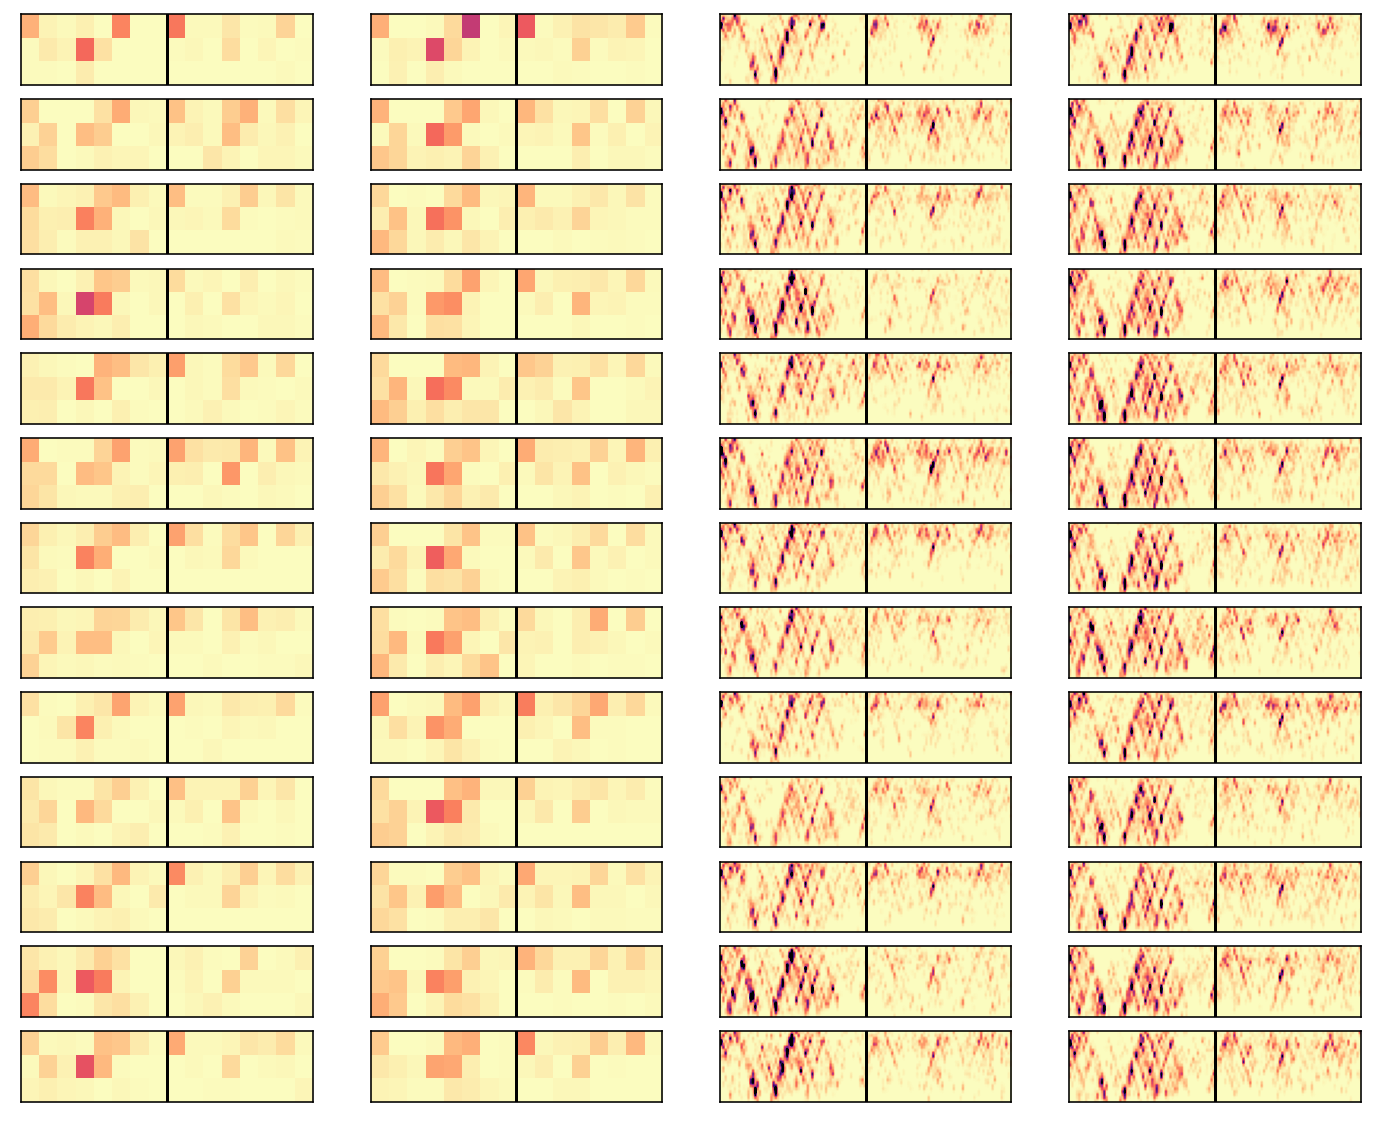

In [266]:
import cv2

imgs = vit_data.all_imgs_untransformed

plt.figure(figsize=(12, 10))
for i in range(len(times)):
    
    time = times[i]    
    
    plt.subplot(len(times), 4, (i*4)+1)
    plt.imshow(new_imgs[i, 0], vmax=0.5, origin='lower', cmap='magma_r', extent=[-16, 16, 0, 3], aspect='auto')
    plt.axvline(0, c='black')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(len(times), 4, (i*4)+2)
    plt.imshow(new_imgs[i, 1], vmax=0.5, origin='lower', cmap='magma_r', extent=[-16, 16, 0, 3], aspect='auto')
    plt.axvline(0, c='black')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(len(times), 4, (i*4)+3)
    plt_hm(gene_name, time, 0, imgs, None)
    
    plt.subplot(len(times), 4, (i*4)+4)
    plt_hm(gene_name, time, 1, imgs, None)
    

In [267]:
import h5py

# save the array to an HDF5 file
with h5py.File('output/deconvolution/clb2_3x16.h5', 'w') as f:
    f.create_dataset('data', data=scaled_imgs)


In [231]:
# import h5py

# # save the array to an HDF5 file
# with h5py.File('output/deconvolution/clb2_6x32.h5', 'w') as f:
#     f.create_dataset('data', data=new_imgs)


In [268]:
# open the HDF5 file
filename = 'output/deconvolution/clb2_3x16_deconvolved.h5'
f = h5py.File(filename, 'r')

# read the dataset into a numpy array
deconvolved_clb2 = f['/data'][:]
deconvolved_clb2.shape

(259, 3, 16)

In [269]:
# # open the HDF5 file
# filename = 'output/deconvolution/clb2_6x32_deconvolved.h5'
# f = h5py.File(filename, 'r')

# # read the dataset into a numpy array
# deconvolved_clb2 = f['/data'][:]
# deconvolved_clb2.shape

In [313]:

def create_axs(heatmaps):
    # customize the heatmap appearance using matplotlib
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4))
    im = ax1.imshow(heatmaps[0], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 256], aspect='auto')
    ax1.set_xticks([])
    ax1.set_yticks([])
    return fig, ax1, ax2, im

def plot_i(im, heatmaps, ax1, ax2, i):
    im.set_data(heatmaps[i])
    ax1.set_title(i)
    ax1.axvline(0, c='black')

    ax2.plot([0, num_frames], [0, 0], c='gray', lw=3)
    ax2.plot(i, 1, 'v-', c='red')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim(-6, 3)


In [ ]:
ax2.cle

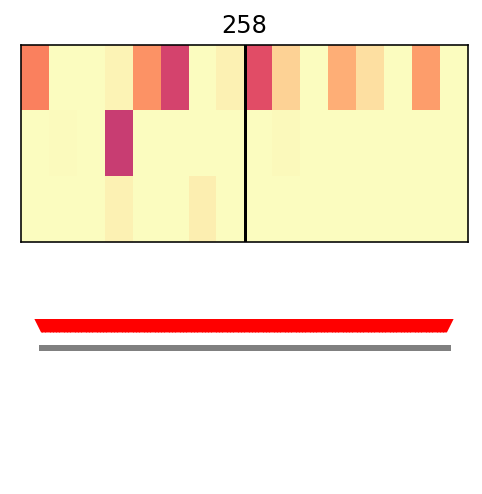

In [314]:
# create a series of 2D numpy arrays
num_frames = deconvolved_clb2.shape[0]
heatmaps = deconvolved_clb2

# create a list of filenames for the frames
filenames = ['output/deconvolution/clb2/clb2_deconvolved_{}.png'.format(i) for i in range(num_frames)]

# customize the heatmap appearance using matplotlib
fig, ax1, ax2, im = create_axs(heatmaps)

# save each heatmap as a PNG file
for i in range(num_frames):
    plot_i(im, heatmaps, ax1, ax2, i)
    fig.savefig(filenames[i])


In [271]:
import imageio

# create an animated GIF from the PNG files
with imageio.get_writer('output/deconvolution/clb2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


In [272]:
num_frames

259

In [284]:
f_initial = pd.read_csv('output/deconvolution/f_initial.csv').columns.astype(int).values-1
f_top = pd.read_csv('output/deconvolution/f_top.csv').columns.astype(int).values-1
f_bottom = pd.read_csv('output/deconvolution/f_bottom.csv').columns.astype(int).values-1

In [288]:
f_initial

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 26

In [286]:
heatmaps[f_bottom-1]

array([[[4.37650395e-10, 2.42918757e-01, 8.56006146e-15, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.95991976e-01, 4.49074084e-02, 0.00000000e+00, ...,
         1.68826143e-02, 8.21825862e-11, 0.00000000e+00],
        [4.08092634e-09, 8.45500475e-10, 1.54607446e-10, ...,
         1.31247755e-10, 4.20022711e-01, 2.36506492e-10]],

       [[5.90502422e-12, 6.11238289e-10, 1.70390873e-10, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.59019717e-10, 1.34974769e-02, 0.00000000e+00, ...,
         5.19182781e-10, 2.17450192e-12, 0.00000000e+00],
        [7.74625288e-01, 2.58033174e-10, 2.43128459e-10, ...,
         5.63898358e-10, 5.72080948e-01, 9.29694946e-10]],

       [[6.12470754e-12, 7.52879041e-10, 1.69701163e-10, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.66524648e-10, 1.00129291e-02, 0.00000000e+00, ...,
         2.25041179e-09, 2.25166579e-12, 0.00000000e+00],
        [7.86252364e-01, 2.43607502e